In [13]:
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image

def generate_image_from_saved_model(label_str, latent_dim=64, device="cpu"):
    # Load the trained model for the specific label
    model_path = f"Trained model/vae_{label_str}.pth"
    
    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"Unable to generate image: Model not found.")
        return None

    vae = VAE(latent_dim=latent_dim).to(device)
    vae.load_state_dict(torch.load(model_path))
    vae.eval()

    # Generate a random latent vector
    latent_sample = torch.randn(1, latent_dim).to(device)

    # Generate the image using the VAE model
    with torch.no_grad():
        generated_image = vae.decode(latent_sample).cpu()

    # Check if generated image is valid
    if generated_image is None:
        print("Error: Generated image is None.")
        return None

    # Convert to NumPy array (HWC format) and rescale
    generated_image = generated_image.squeeze(0).permute(1, 2, 0).numpy()
    generated_image = (generated_image * 255).astype('uint8')  # Convert to image format

    return generated_image


In [14]:
def save_generated_image(generated_image, save_folder="generated_images", image_name="generated_image.png"):
    # Ensure the folder exists
    os.makedirs(save_folder, exist_ok=True)

    if generated_image is None:
        print("Error: No image to save.")
        return

    # Convert the NumPy array to a PIL Image
    pil_image = Image.fromarray(generated_image)

    # Save the image to the specified folder
    save_path = os.path.join(save_folder, image_name)
    pil_image.save(save_path)
    print(f"Image saved as {save_path}")


In [17]:
# Generate the image
prompts = ["red_shirt", "blue_shirt", "green_shirt", "red_shirt_stripe", "blue_shirt_stripe", "green_shirt_stripe", "red_shirt_checker", "blue_shirt_checker", "green_shirt_checker", "red_shirt_polka", "blue_shirt_polka", "green_shirt_polka", "black_pants", "blue_pants", "green_pants", "black_pants_stripe", "blue_pants_stripe", "green_pants_stripe", "red_pants_polka", "blue_pants_polka", "green_pants_polka", "black_pants_checker", "blue_pants_checker", "red_pants_checker"]
for prompt in prompts:
    generated_image = generate_image_from_saved_model(prompt)
    save_generated_image(generated_image, save_folder="generated_images", image_name=f"{prompt}.png")



C:\Users\rayau\AppData\Local\Temp\ipykernel_8648\3330631466.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


Image saved as generated_images\red_shirt.png
Image saved as generated_images\blue_shirt.png
Image saved as generated_images\green_shirt.png
Image saved as generated_images\red_shirt_stripe.png
Image saved as generated_images\blue_shirt_stripe.png
Image saved as generated_images\green_shirt_stripe.png
Image saved as generated_images\red_shirt_checker.png
Image saved as generated_images\blue_shirt_checker.png
Image saved as generated_images\green_shirt_checker.png
Image saved as generated_images\red_shirt_polka.png
Image saved as generated_images\blue_shirt_polka.png
Image saved as generated_images\green_shirt_polka.png
Image saved as generated_images\black_pants.png
Image saved as generated_images\blue_pants.png
Image saved as generated_images\green_pants.png
Image saved as generated_images\black_pants_stripe.png
Image saved as generated_images\blue_pants_stripe.png
Image saved as generated_images\green_pants_stripe.png
Image saved as generated_images\red_pants_polka.png
Image saved as

In [18]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os

# Load the pretrained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()

# Preprocessing transformation (same as used when training InceptionV3)
preprocess = transforms.Compose([
    transforms.Resize(299),  # InceptionV3 expects images of size 299x299
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def calculate_inception_score(images_folder, splits=10):
    """
    Calculate the Inception Score for a set of images.
    Args:
    - images_folder (str): Path to folder containing images to evaluate.
    - splits (int): Number of splits for calculating the inception score.

    Returns:
    - Inception score value
    """
    # Get list of image filenames in the folder
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]

    # Initialize variables to compute inception score
    all_probs = []

    for image_file in image_files:
        # Open and preprocess image
        img_path = os.path.join(images_folder, image_file)
        img = Image.open(img_path).convert('RGB')
        img = preprocess(img).unsqueeze(0)  # Add batch dimension
        
        # Forward pass through InceptionV3
        with torch.no_grad():
            output = inception_model(img)
        
        # Apply softmax to get probabilities
        probs = F.softmax(output, dim=1)
        all_probs.append(probs)

    # Convert list of probabilities to a tensor (shape: num_images x 1000)
    all_probs = torch.cat(all_probs, dim=0)

    # Compute the marginal distribution (mean over the batch)
    marginal_probs = all_probs.mean(dim=0)

    # Compute KL divergence for each image and calculate Inception Score
    kl_divergence = all_probs * (torch.log(all_probs) - torch.log(marginal_probs))
    inception_score = torch.exp(kl_divergence.mean())

    return inception_score.item()

# Example usage
images_folder = "generated_images"  # Path to the folder with your images
inception_score = calculate_inception_score(images_folder)
print(f"Inception Score: {inception_score:.4f}")


c:\Users\rayau\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rayau\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 1.0011


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Number of distinct clusters: 24
Mode Collapse Score: 0.0000


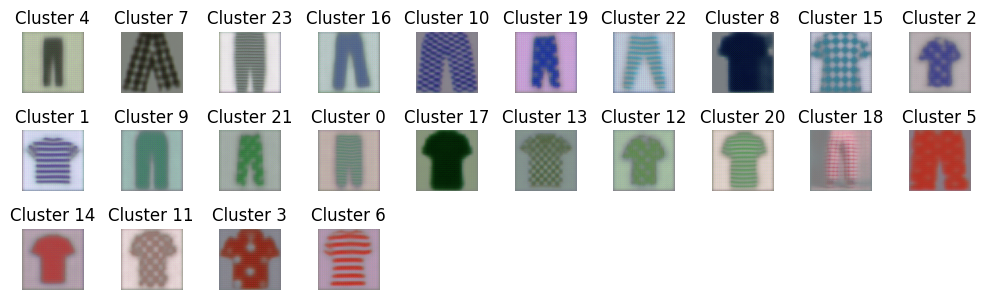

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
def load_inception_model():
    model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
    return model

# Function to load and preprocess images
def preprocess_images(image_paths):
    images = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(299, 299))  # InceptionV3 input size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
        images.append(img_array)
    return np.vstack(images)

# Extract features from the images using the InceptionV3 model
def extract_features(image_paths, model):
    images = preprocess_images(image_paths)
    features = model.predict(images)
    return features

# K-means clustering and calculating Mode Collapse
def calculate_mode_collapse(features, n_clusters=10):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(features)
    
    # Count the number of distinct clusters
    unique_clusters = np.unique(kmeans.labels_)
    n_distinct_clusters = len(unique_clusters)
    
    # Mode collapse score: The fewer clusters, the higher the collapse.
    mode_collapse_score = 1 - (n_distinct_clusters / n_clusters)
    
    return mode_collapse_score, n_distinct_clusters

# Plotting the images with their cluster assignments (optional)
def plot_clusters(image_paths, features, kmeans):
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_paths):
        img = plt.imread(img_path)
        plt.subplot(10, 10, i+1)  # Adjust the grid size (10x10 here)
        plt.imshow(img)
        plt.title(f"Cluster {kmeans.labels_[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main function to compute Mode Collapse score
def main(image_folder, n_clusters=10):
    # Load pre-trained InceptionV3 model
    model = load_inception_model()
    
    # Load all images from the 'generated_images' folder
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.jpg', '.png'))]
    
    # Extract features from images
    features = extract_features(image_paths, model)
    
    # Calculate Mode Collapse score
    mode_collapse_score, n_distinct_clusters = calculate_mode_collapse(features, n_clusters)
    
    # Print the results
    print(f"Number of distinct clusters: {n_distinct_clusters}")
    print(f"Mode Collapse Score: {mode_collapse_score:.4f}")
    
    # Optionally, plot the images with their cluster assignments
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(features)
    plot_clusters(image_paths, features, kmeans)

# Example usage
if __name__ == '__main__':
    image_folder = 'generated_images'  # Replace this with the path to your 'generated_images' folder
    main(image_folder, n_clusters=24)  # Adjust number of clusters as needed
